Here and below is a description of how to interact with the code in the repository. Here are tools for recording datasets from video, training classifiers and autoencoders on them, and applying the resulting models in real-time. 

Let's start by importing the dataset recording module `record_data` and understand how to work with it. All of the necessary modules are in the `tools`.

In [6]:
from tools import record_data

The video processing in this repository is based on the [mediapipe](https://developers.google.com/mediapipe) framework and uses several solution from it, such as **Face Mesh**, **Hand and Pose Landmarks**, **Holistic**. These solutions allow us to find AU (*Action Units*) points on the human body, and we, in turn, can write these points as a vector representation.

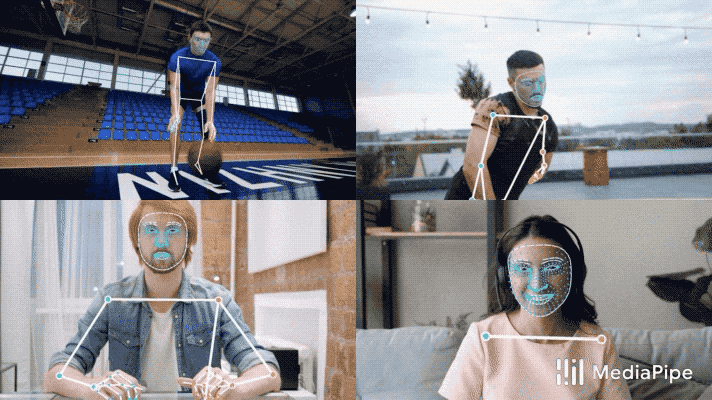

That is, we need to extract AU vectors for further training. But, for example, to solve the problem of gesture recogniton, you will not consider facial expressions or the whole pose, so we do not need this data.

Let's write a sample function call to extract data for future right hand gesture recognition.

In [7]:
recorder = record_data.record_data

In [3]:
recorder(output_file="data.csv",
         num_frames=200,
         right_hand_landmarks=True,
         class_name="Super")

100%|██████████| 200/200 [00:14<00:00, 13.56it/s]


This call accesses the webcam as a source and if there is a subject's right hand in the frame, it creates a vector from AU and writes it to the file `data.csv`. The parameter `num_frames` specifies how many data instances you want to create in the dataset. The parameter `class_name` is used to mark the data instance with a class. If you don't specify this parameter, you have to enter the name of the class anyway in the dialog box.

**All parameters**:
* `output_file: str`
* `num_frames: int`
* `pose_landmarks: bool`
* `face_landmarks: bool`
* `left_hand_landmarks: bool`
* `right_hand_landmarks: bool`
* `pose_cut: bool` we will talk about this parameter later
* `class_name: str`
* `source: str` or `int`

If you don't have a webcam, or if you need to extract features from a pre-recorded video, specify `source` as the parameter (on default `source=0`). 

In [3]:
recorder(output_file="data.csv",
         num_frames=200,
         right_hand_landmarks=True,
         class_name="Super",
         source='anomaly_data/CAM2/Andrey/normal/normal_1.mp4')

 22%|██▏       | 43/200 [00:08<00:31,  4.91it/s]


In the example above, the program could not recognize 200 frames with the right hand in this video, so it recorded only 43. 

**An important reminder:** if you specify the same name for output file, the data is added to it, not overwritten.

Now let's create a dataset on which we will teach the model to recognize the super and peace geasture sign. To do this, let's run the function twice and specify different class names. Then we can represent these two classes in front of the webcam.

In [4]:
recorder(output_file="geasture_dataset.csv",
         num_frames=200,
         right_hand_landmarks=True,
         class_name="Super")

100%|██████████| 200/200 [00:10<00:00, 19.19it/s]


In [5]:
recorder(output_file="geasture_dataset.csv",
         num_frames=200,
         right_hand_landmarks=True,
         class_name="Peace")

100%|██████████| 200/200 [00:13<00:00, 15.09it/s]


Now we have a finished dataset with 400 data instances, 200 of each class. Let's start training classifier on this data.

In [3]:
from tools import train

c:\Users\da0c\.virtualenvs\Psychological-Deviation-Detection-qqTVH8wi\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There are 5 functions in the `train` module that you need to be aware of. We'll go through them all and start with the simplest one, namely `train_classifier`. 

Let's first create a classifier model for our dataset, and then learn in detail how to work with it.

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
simple_trainer = train.train_classifier

In [5]:
pipeline = {
    'RFC': make_pipeline(StandardScaler(), RandomForestClassifier()),
    'GBC': make_pipeline(StandardScaler(), GradientBoostingClassifier())
}

In [13]:
simple_trainer(data_file="geasture_dataset.csv",
               pipelines=pipeline,
               output_name="single_geasture",
               test_size=0.2,
               test=True)

for RFC algorythm:
accuracy score:               precision    recall  f1-score   support

       Peace       1.00      1.00      1.00        46
       Super       1.00      1.00      1.00        74

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120

for GBC algorythm:
accuracy score:               precision    recall  f1-score   support

       Peace       1.00      1.00      1.00        46
       Super       1.00      1.00      1.00        74

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



The function call lists almost all the parameters it has. The `data_file` specifies which data to use for training. `output_name` will use the prefix for the final model name. `test_size` indicates how much data you will need to test the model (the rest will go for training). `test` is bool parameter indicates whether you will need to test the data with the resulting model and will output the results.

Separately, it is worth talking about the parameter `pipelines`. The points is that you can specify the models on which you want to train your classifier using the implementation from **scikit-learn** `make_pipeline`. It is a dictionary, where the key is the nae of the pipeline (this key will also be used to create a file name), and the value is the pipeline you created.

In this case there will be two output models in the `models` folder, names `geasture_GBC.pkl` and `geasture_RFC.pkl`, which use the corresponding algorithms to solve the classification problem.

There is also such a problem: when it comes to video classification, you may need to consider not only a particular frame for purpose, but also neighboring frames (e.g. previous ones). If you need to condiser not only current but also previous frames, you need the `neighbors` parameter.

In [14]:
simple_trainer(data_file="geasture_dataset.csv",
               pipelines=pipeline,
               output_name="geasture_time",
               test_size=0.2,
               test=True,
               neighbors=[-5, -2])

c:\Users\da0c\Desktop\works\Psychological-Deviation-Detection\tools\train.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f"{col}_{i}"] = df[col].shift(i)
c:\Users\da0c\Desktop\works\Psychological-Deviation-Detection\tools\train.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_copy[f"{col}_{i}"] = df[col].shift(i)
c:\Users\da0c\Desktop\works\Psychological-Deviation-Detection\tools\train.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times,

for RFC algorythm:
accuracy score:               precision    recall  f1-score   support

       Peace       1.00      1.00      1.00        36
       Super       1.00      1.00      1.00        83

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119

for GBC algorythm:
accuracy score:               precision    recall  f1-score   support

       Peace       1.00      1.00      1.00        36
       Super       1.00      1.00      1.00        83

    accuracy                           1.00       119
   macro avg       1.00      1.00      1.00       119
weighted avg       1.00      1.00      1.00       119



In this parameter you feed the negative integer numbers of the previous frames that you want to take into account in the model. In the example above, the model will consider not only the current frame for classificationm but also the two frames before the current one, namely two frames and five frames bedore the current one.